In [58]:
import pandas as pd
import pandas_datareader as web
from pandas.tseries.offsets import DateOffset
import datetime as dt
import hvplot.pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from finta import TA

## Import and process data

In [59]:
# Get "High" Beta stock data for 10 years
stock = "OSTK"
start = dt.datetime(2010, 1, 1)
ostk_df = web.DataReader(stock, 'yahoo', start) 

In [60]:
ostk_df["Actual Returns"] = ostk_df["Close"].pct_change()
ostk_df = ostk_df.dropna()

In [61]:
# Add MACD indicators
ostk_macd_df = TA.MACD(ostk_df)

In [62]:
# Join DataFrames
ostk_combined_df = pd.concat([ostk_df, ostk_macd_df], axis=1)

In [63]:
ostk_combined_df.head()

,High,Low,Open,Close,Volume,Adj Close,Actual Returns,MACD,SIGNAL
Date,,,,,,,,,
2010-01-05,14.08,13.37,13.65,13.81,151400,13.81,0.007294,0.000000,0.000000
2010-01-06,13.75,13.17,13.75,13.20,113600,13.20,-0.044171,-0.013686,-0.007603
2010-01-07,13.51,12.79,13.23,13.24,179900,13.24,0.003030,-0.016198,-0.011126
2010-01-08,13.39,12.89,13.24,13.10,103400,13.10,-0.010574,-0.021998,-0.014809
2010-01-11,13.45,12.96,13.15,13.27,125300,13.27,0.012977,-0.017922,-0.015735


In [64]:
# Create a trading algorithm using MACD
# Set the Signal column
ostk_combined_df["Buy/Sell"] = 0.0

# Generate the trading signals 1 (entry) or -1 (exit) for a long position trading algorithm
# where 1 is when the MACD is greater than the SIGNAL
# where -1 is when the MACD is less than the SIGNAL
for index, row in ostk_combined_df.iterrows():
    if row["MACD"] > row["SIGNAL"]:
        ostk_combined_df.loc[index, "Buy/Sell"] = 1.0
    if row["MACD"] < row["SIGNAL"]:
        ostk_combined_df.loc[index,"Buy/Sell"] = -1.0

# Add "Inflection Point" column to the DataFrame where MACD & SIGNAL cross (this will indicated Buy/Sell) 
ostk_combined_df["Indicator Point"] = 0.0
ostk_combined_df["Indicator Point"] = round(ostk_combined_df["Buy/Sell"].diff() / 2)
ostk_combined_df

,High,Low,Open,Close,Volume,Adj Close,Actual Returns,MACD,SIGNAL,Buy/Sell,Indicator Point
Date,,,,,,,,,,,
2010-01-05,14.080000,13.370000,13.650000,13.810000,151400,13.810000,0.007294,0.000000,0.000000,0.0,NaN
2010-01-06,13.750000,13.170000,13.750000,13.200000,113600,13.200000,-0.044171,-0.013686,-0.007603,-1.0,-0.0
2010-01-07,13.510000,12.790000,13.230000,13.240000,179900,13.240000,0.003030,-0.016198,-0.011126,-1.0,0.0
2010-01-08,13.390000,12.890000,13.240000,13.100000,103400,13.100000,-0.010574,-0.021998,-0.014809,-1.0,0.0
2010-01-11,13.450000,12.960000,13.150000,13.270000,125300,13.270000,0.012977,-0.017922,-0.015735,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-29,52.299999,47.689999,47.970001,51.700001,1446700,51.700001,0.090027,-0.147331,-0.216222,1.0,1.0
2022-03-30,50.480000,46.310001,50.080002,46.720001,2348200,46.720001,-0.096325,-0.338786,-0.240735,-1.0,-1.0
2022-03-31,47.119999,44.000000,47.119999,44.009998,1966000,44.009998,-0.058005,-0.701109,-0.332810,-1.0,0.0


In [65]:
# Drop NaN rows
ostk_combined_df = ostk_combined_df.dropna()

In [66]:
# Identify duplicate rows
ostk_combined_df[ostk_combined_df.index.duplicated()]

# Remove duplicate rows
ostk_combined_df = ostk_combined_df[~ostk_combined_df.index.duplicated(keep='first')]

In [67]:
# Visualize entry position relative to close price
entry = ostk_combined_df[ostk_combined_df["Indicator Point"] > 0.0]["Close"].hvplot.scatter(
    color="green",
    marker="^",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = ostk_combined_df[ostk_combined_df["Indicator Point"] < 0.0]["Close"].hvplot.scatter(
    color="red",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400
)
security_close = ostk_combined_df[["Close"]].hvplot(
    line_color="lightgray",
    ylabel="Price in $",
    width=1000,
    height=400
)

macd = ostk_combined_df[["MACD"]].hvplot(
    line_color="purple",
    ylabel="Price in $",
    width=1000,
    height=400
)


signal = ostk_combined_df[["SIGNAL"]].hvplot(
    line_color="orange",
    ylabel="Price in $",
    width=1000,
    height=400
)

macd_plot = security_close * macd * signal * entry * exit
macd_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (MACD)
   .Curve.III        :Curve   [Date]   (SIGNAL)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Create Model to predict MACD indicator

In [68]:
# Create Test/Train DataFrames
X = ostk_combined_df[["MACD", "SIGNAL"]].shift().dropna().copy()

y = ostk_combined_df["Buy/Sell"].shift().dropna().copy()

In [69]:
# Get length of Dataframe
df_len = ostk_combined_df.shape[0]

# Get 70% for test data
test_len = round(df_len * 0.8)

In [70]:
# Set beginning and end of Training data
training_begin = X.index.min()
training_end = X.index.min() + pd.tseries.offsets.BusinessDay(n = test_len)

# Convert to Datetime to match index
temp1 = training_begin.to_pydatetime()
temp2 = training_end.to_pydatetime()

# Strip time
training_begin = temp1.strftime('%Y-%m-%d')
training_end = temp2.strftime('%Y-%m-%d')

In [71]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [72]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [73]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [74]:
# Create the classifier model
svm_model = svm.SVC()

print(type(X_train_scaled))
print(type(y_train))
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [75]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display the report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97      1134
         1.0       0.97      0.98      0.97      1246

    accuracy                           0.97      2380
   macro avg       0.97      0.97      0.97      2380
weighted avg       0.97      0.97      0.97      2380



In [76]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [77]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.94      0.95      0.94       276
         1.0       0.96      0.96      0.96       427

    accuracy                           0.95       703
   macro avg       0.95      0.95      0.95       703
weighted avg       0.95      0.95      0.95       703



In [78]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["Predicted Signal"] = testing_signal_predictions

predictions_df["Actual Returns"] = ostk_combined_df["Actual Returns"]

predictions_df["MACD Algo Returns"] = (
    predictions_df["Actual Returns"] * predictions_df["Predicted Signal"]
)

# Review the DataFrame
predictions_df.head()

,Predicted Signal,Actual Returns,MACD Algo Returns
Date,,,
2019-06-21,1.0,0.154691,0.154691
2019-06-24,1.0,-0.044944,-0.044944
2019-06-25,1.0,-0.026244,-0.026244
2019-06-26,1.0,0.254647,0.254647
2019-06-27,1.0,-0.035556,-0.035556


<AxesSubplot:xlabel='Date'>

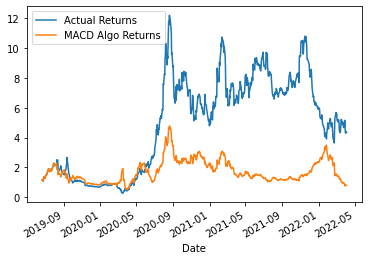

In [79]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["Actual Returns", "MACD Algo Returns"]]).cumprod().plot()

In [ ]:
ostk_macd_df = TA.MFI(ostk_df)